In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import functools
%matplotlib inline

In [130]:
def extract_data(excel, fill_method = 'linear'):
    """
    Extracts sheets names from an imported excel and returns a list containing the names
    input -> (string) path/filename
          -> (string) way for filling NaN values
    output -> dataframe with adjusted data (i)
    """
    
    xls = pd.ExcelFile(excel)
    df = xls.parse(sheet_name=0)
    pivot = df.columns[0]
    
    for sheet in xls.sheet_names[1:]:
        df = pd.merge(df, xls.parse(sheet_name=sheet), on=pivot, how='outer')
    
    df = df.sort_values(by=pivot).set_index([pivot])
    
    #Select the moment from which all the columns have values (not NaN)
    start_index = 0
    for index,columns in df.iterrows():
    
        if True in [np.isnan(columns[col]) for col in range(0, len(columns))]:
            continue
        else: 
            start_index = index
            break
    
    df.interpolate(method='linear', axis=0, inplace=True)

    return df.loc[start_index:]

In [131]:
df = extract_data('australia.xlsx')

In [132]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [141]:
def regress_data(data, x_col, y_col, degree = 1, test = 0.05, validation = 0.3, prepap = 'standardize'):
    """
    Apply regression on dataframe, by specifying degree of regression (polynomial)
    
    input:
        -> data - Dataframe containing all variables (both dependent and independent ones)
        -> x - list containing column numbers you wish to set as independent variables
        -> y - integer referring to the column number you wish to se as dependent variable
        -> degree - degree of regression (default set to 0, as in linear regression)
        -> test - float referring to weight test data out of total data (default is set to 5% test - 95% training data)
        -> validation - floate referring to weight validation data out of training data (default is set to 20% validation
                        data - 80% train data)
                        
        ex: total data = training data(95%) + test data(5%)
            training data = train data(80%) + validation data(20%)
    
    output: 
        -> print dataframe with p-value for each independet variable
        -> print rmse (root-mean-square error)
        -> print r-squared
        -> print graphic representation for (test - result data, compared to actual data)
    """
    
    X, y = 0, 0
    X_columns = 0 
    
    if prepap == 'standardize':
        X = data.iloc[:,x_col]
        y = data.iloc[:,[y_col]]
        X_columns = X.columns
        
        scaler_X = StandardScaler() 
        scaler_y = StandardScaler()
        X = scaler_X.fit_transform(X)
        y = scaler_y.fit_transform(y)
        
    elif prepap == 'percent':
        X = data.iloc[:,x_col]
        y = data.iloc[:,[y_col]]
        X = X.pct_change()[1:]
        y = y.pct_change()[1:]
        X_columns = X.columns
    
    else: 
        X = data.iloc[:,x_col]
        y = data.iloc[:,[y_col]]
        X_columns = X.columns
        
    
    
    #Splitting data into training-test sets
    split_index = int((1-test)*len(X))
    X_training, X_test = X[:split_index], X[split_index:]
    y_training, y_test = y[:split_index], y[split_index:]
    
    #Splitting data into train-validation sets
    X_train, X_validation, y_train, y_validation = train_test_split(X_training, y_training, test_size = validation)
    
    
    #Building polynomial feature
    polynomial_features = PolynomialFeatures(degree=degree)
    
    #Building independent variables for polynomial regression
    X_train_pol = polynomial_features.fit_transform(X_train)
    X_valid_pol = polynomial_features.fit_transform(X_validation)
    X_test_pol = polynomial_features.fit_transform(X_test)
    
    #Creating model
    model = sm.OLS(y_train, X_train_pol).fit()
    
    #Predicting with test data
    y_pred = model.predict(X_valid_pol)
    
    #Calculating error metrics for test data set
    if prepap != 'standardize': y_validation = y_validation.values
    
    diff_valid = y_pred - y_validation.reshape(-1)
    mse_validation = (diff_valid**2).sum()/len(diff_valid)
    rmse_validation = np.sqrt(mse_validation)
    mae_validation = np.abs(diff_valid).sum()
    
    #Forecast with test data set
    y_forecast_pol = model.predict(X_test_pol)
    
    #Returnin to raw data
    y_forecast = 0
    if prepap == 'standardize':
        y_forecast = scaler_y.inverse_transform(y_forecast_pol)
    elif prepap == 'percent':
        init = y.iloc[split_index-1].values[0]
        y_forecast = (1 + y_forecast_pol) * init
    else: 
        y_forecast = y_forecast_pol
        
    #Building results in a dictionar        
    if prepap != 'standardize': y_test = y_test.values
    result = {'model_specs':{'degree':degree,
                             'X_columns': list(X_columns), 
                             'period':[df.iloc[0].name, df.iloc[-1].name],
                             'test_period':[df.iloc[0].name, df.iloc[-1].name]},
              'fcast_vs_real':[y_forecast,y_test.reshape(-1)],
              'valid_metrics':[mse_validation, rmse_validation, mae_validation]}
    
    return result

In [142]:
result = regress_data(df,x_col=[0,1,2,4,6], y_col = 8, degree= 1, prepap='percent')

In [154]:
mse_error, rmse_error, mae_error = [], [], []

for degree in range(1,6):
    result = regress_data(df,x_col=[0,1,2,4,6], y_col = 8, degree= degree, prepap='percent')
    mse_error.append(result['valid_metrics'][0])
    rmse_error.append(result['valid_metrics'][1])
    mae_error.append(result['valid_metrics'][2])

In [155]:
rmse_error

[0.0072125209169715135,
 0.0071222280981502375,
 0.007890132507063812,
 0.020829606156954908,
 0.06174146917395005]

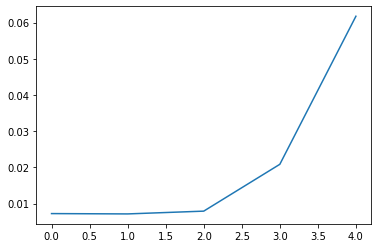

In [156]:
plt.plot(rmse_error)